In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
#!pip install facenet-pytorch opencv-python scikit-learn ipywidgets matplotlib

In [2]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision.transforms.functional import to_pil_image
import cv2
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

## Извлечение кадров и лиц из видео для датасета

In [3]:
# Модель для детекции лиц
mtcnn = MTCNN(image_size=160, margin=20, keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

def extract_faces_from_video(video_path, output_dir, frame_step=5):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_num = 0
    face_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_num += 1
        if frame_num % frame_step != 0:
            continue
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(img)
        if boxes is not None:
            faces = mtcnn.extract(img, boxes, save_path=None)
            for i, face in enumerate(faces):
                face_img = to_pil_image(face)
                face_img.save(f"{output_dir}/face_{frame_num}_{i}.jpg")
                face_id += 1
    cap.release()
    print(f"Извлечено {face_id} лиц из {video_path} в {output_dir}")

# Извлекаем лица из первого видео в dataset/Ergashev
extract_faces_from_video('v1.mp4', 'dataset/Ergashev')

# Извлекаем лица из второго видео в dataset/Reshetnikov
extract_faces_from_video('v2.mp4', 'dataset/Reshetnikov')

# Извлекаем лица из второго видео в dataset/JimCarrey
extract_faces_from_video('v3.mp4', 'dataset/JimCarrey')


Извлечено 373 лиц из v1.mp4 в dataset/Ergashev
Извлечено 435 лиц из v2.mp4 в dataset/Reshetnikov
Извлечено 325 лиц из v3.mp4 в dataset/JimCarrey


## Дообучение FaceNet (на классификацию)

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Подготовка датасета
data_dir = 'dataset'  # путь к папке с папками людей
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Модель FaceNet
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Извлекаем embeddings
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in tqdm(loader):
        emb = resnet(imgs)
        embeddings.append(emb)
        labels.append(lbls)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

# Обучаем классификатор
clf = LogisticRegression(max_iter=1000)
clf.fit(embeddings, labels)

# Тестирование
preds = clf.predict(embeddings)
print('Accuracy:', accuracy_score(labels, preds))

100%|██████████| 36/36 [00:16<00:00,  2.23it/s]

Accuracy: 0.9955869373345102


## Распознавание новых лиц на видео

In [5]:
def recognize_faces_in_video(video_path, clf, resnet, mtcnn, class_names):
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt

    cap = cv2.VideoCapture(video_path)
    frame_num = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_num += 1

        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(img)
        if boxes is not None:
            faces = mtcnn.extract(img, boxes, save_path=None)
            for i, (face, box) in enumerate(zip(faces, boxes)):
                face_tensor = face.unsqueeze(0)
                emb = resnet(face_tensor).detach().numpy()
                pred = clf.predict(emb)
                name = class_names[pred[0]]

                # Координаты прямоугольника
                x1, y1, x2, y2 = map(int, box)
                # Рисуем прямоугольник
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Подписываем имя
                cv2.putText(frame, name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.9, (0, 255, 0), 2)

        # Раз в 30 кадров выводим картинку в ноутбук
        if frame_num % 30 == 0:
            # Переводим BGR -> RGB для правильного отображения в ноутбуке
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            plt.figure(figsize=(8, 6))
            plt.axis('off')
            plt.imshow(rgb_frame)
            plt.show()

        # Показываем кадр в отдельном окне
        cv2.imshow('Face Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


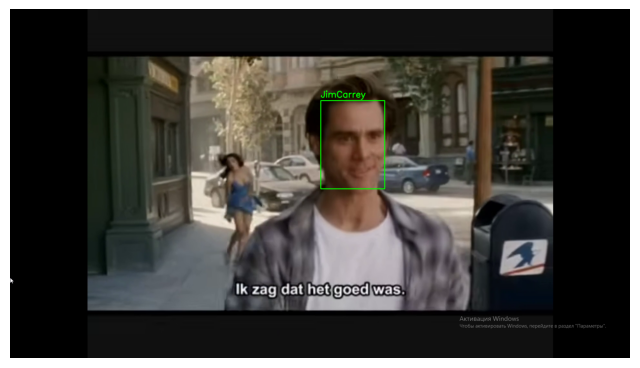

In [7]:
class_names = dataset.classes
recognize_faces_in_video('test_JimCarrey.mp4', clf, resnet, mtcnn, class_names)